In [1]:
import pandas as pd
import numpy as np
import torch
import cv2
import math
import os
import matplotlib.pyplot as plt
import zipfile

In [2]:
import tensorflow
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tensorflow.__version__

2024-10-29 11:24:39.443326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 11:24:39.452817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 11:24:39.464469: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 11:24:39.467701: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 11:24:39.476282: I tensorflow/core/platform/cpu_feature_guar

'2.17.0'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
    try: 
        tensorflow.config.set_logical_device_configuration(gpus[0], [tensorflow.config.LogicalDeviceConfiguration(memory_limit=3900)])
        logical_gpus = tensorflow.config.list_logical_devices('GPU')
        print(len(gpus), "Phyisical GPUs, ", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


'''
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tensorflow.config.experimental.set_memory_growth(gpu, True)'''

In [3]:
df = pd.read_csv('./fer2013/fer2013.csv')
pixels = df['pixels'].to_list()

In [4]:
image_size = 48

In [5]:
faces = []
for image in pixels:
    face = [int(pixel) for pixel in image.split(' ')]
    face = np.asarray(face).reshape(image_size, image_size)
    faces.append(face)

In [6]:
faces = np.asarray(faces)

In [7]:
faces.shape

(35887, 48, 48)

In [8]:
faces = np.expand_dims(faces, -1)

In [9]:
faces.shape

(35887, 48, 48, 1)

In [10]:
def normalize(x):
    x = x.astype('float32')
    return x/255

faces = normalize(faces)

In [11]:
emocoes = pd.get_dummies(df['emotion']).values

In [12]:
emotions = ["Angry", "Disgusted", "Afraid", "Happy", "Neutral", "Sad", "Surprised"]

In [13]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48
model = Sequential()
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
input_shape=(width, height, 1), data_format = 'channels_last',
kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax'))
model.summary()

/home/zanchet/dev/LAMIA/LAMIA_venv/lib64/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730211905.855957   11919 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730211905.858167   11919 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730211905.859243

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,905,863 (22.53 MB)

 Trainable params: 5,902,151 (22.51 MB)

 Non-trainable params: 3,712 (14.50 KB)

num_features = 64
num_labels = 7 #len(emotions)
epochs = 100
batch_size = 8
width, height = image_size, image_size

i = Input(shape=(width, height, 1))
x = Conv2D(num_features, kernel_size = (3,3), activation="relu", padding = 'same', kernel_regularizer = l2(0.01))(i)
x = Conv2D(num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Conv2D(2*2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = Conv2D(2*2*2*num_features, kernel_size = (3,3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)
x = Dropout(0.3)(x)

x = Flatten()(x)

x = Dense(2*2*2*num_features, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(2*2*num_features, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(2*num_features, activation='relu')(x)
x = Dropout(0.5)(x)

o = Dense(num_labels, activation='softmax')(x)

model = Model(inputs = i, outputs = o, name='Emotion_recon_3000')

model.summary()

#model.compile(optimizer = Adam(weight_decay=None, learning_rate=0.9), loss = 'categorical_crossentropy', metrics = ['accuracy'])

num_features = 64
num_labels = 7
epochs = 100
width, height = image_size, image_size

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

In [14]:
model_file = 'expression_recognition_01.keras'

In [15]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.keras'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.8, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_accuracy', verbose = 1, save_best_only=True)

history = model.fit(training_data_normalized,
                    epochs = epochs,
                    steps_per_epoch = 10,
                    validation_data = validation_data_normalized,
                    callbacks = [lr_reducer, checkpointer],
                    validation_steps = 10)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(faces, emocoes, test_size=0.15, random_state=42)

In [17]:
history = model.fit(np.array(X_train), np.array(y_train),
batch_size = batch_size,
epochs = epochs,
verbose = 1,
validation_data = (np.array(X_val), np.array(y_val)),
shuffle=True,
callbacks=[lr_reducer, checkpointer])

Epoch 1/100


I0000 00:00:1730211942.135770   11990 service.cc:146] XLA service 0x7f3b5c013d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730211942.135793   11990 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-10-29 11:25:42.215905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 11:25:42.619500: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  3/477 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.1458 - loss: 5.8566 

I0000 00:00:1730211951.636147   11990 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2000 - loss: 2.3031

2024-10-29 11:26:26.817515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_274', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.24276, saving model to modelo_01_expressoes.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 49s 77ms/step - accuracy: 0.2000 - loss: 2.3025 - val_accuracy: 0.2428 - val_loss: 1.8187 - learning_rate: 0.0010
Epoch 2/100
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2473 - loss: 1.8414
Epoch 2: val_accuracy improved from 0.24276 to 0.24350, saving model to modelo_01_expressoes.keras
477/477 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.2473 - loss: 1.8414 - val_accuracy: 0.2435 - val_loss: 1.8181 - learning_rate: 0.0010
Epoch 3/100
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2563 - loss: 1.8070
Epoch 3: val_accuracy did not improve from 0.24350
477/477 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.2563 - loss: 1.8070 - val_accuracy: 0.1543 - val_loss: 2.0068 - learning_rate: 0.0010
Epoch 4/100
476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3084 - loss: 1.7166
Epoch 4: val_accuracy did not improve from 0.24350
477/477 ━

In [ ]:
history

In [18]:
loaded_model = tensorflow.keras.models.load_model('modelo_01_expressoes.keras')

In [19]:
Y_predicted = loaded_model.predict(X_val)

169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


In [20]:
yp = Y_predicted.tolist()
yt = y_val.tolist()
y_pred = []
y_true = []

In [21]:
len(yp)

5384

In [22]:
len(yt)

5384

In [23]:
for i in range(len(yt)):
    y_pred.append(np.argmax(yp[i]))
    y_true.append(np.argmax(yt[i]))

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
cm = confusion_matrix(y_true, y_pred)

In [26]:
print(cm)

[[ 425   12   64   42   94    6  112]
 [  22   46    5    2    4    1    1]
 [  86    6  356   43  165   56   89]
 [  33    0   15 1136   31   22   70]
 [  96    0   65   45  501    2  191]
 [  12    1   71   44   10  447   16]
 [  57    1   34   75  123    8  641]]


([<matplotlib.axis.YTick at 0x7f3c35732c90>,
 [Text(0, 0, 'Angry'),
  Text(0, 1, 'Disgusted'),
  Text(0, 2, 'Afraid'),
  Text(0, 3, 'Happy'),
  Text(0, 4, 'Neutral'),
  Text(0, 5, 'Sad'),
  Text(0, 6, 'Surprised')])

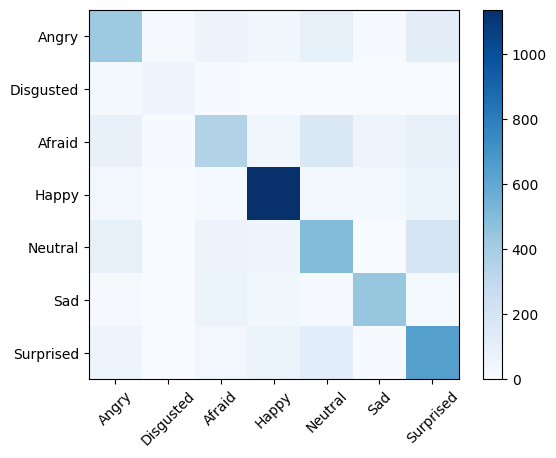

In [27]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(emotions))
plt.xticks(tick_marks, emotions, rotation = 45)
plt.yticks(tick_marks, emotions, rotation = 0)

## Testando o modelo

In [28]:
img_path = './Material/testes/teste02.jpg'
image = cv2.imread(img_path)

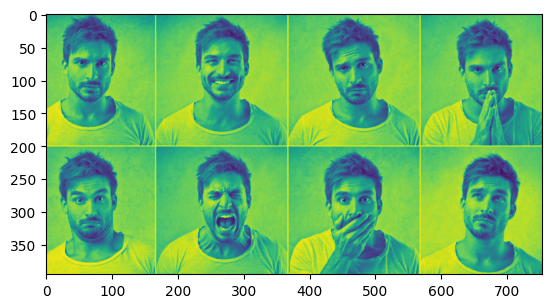

In [29]:
original = image.copy()
grayscale = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale)

In [30]:
face_detector = cv2.CascadeClassifier('./Material/haarcascade_frontalface_default.xml')
faces = face_detector.detectMultiScale(grayscale, 1.1, 3)

In [31]:
for (x, y, w, h) in faces:
    original = cv2.rectangle(original, (x, y), (x + w, y + h), (255, 0, 0), 1)
    roi_gray = grayscale[y:y+h, x:x + w]
    roi_gray = normalize(roi_gray)
    roi_gray = cv2.resize(roi_gray, (image_size, image_size))
    dimensioned = np.expand_dims(roi_gray, -1)
    dimensioned = np.expand_dims(dimensioned, 0)
    prediction = loaded_model.predict(dimensioned)[0]
    label = emotions[int(np.argmax(prediction))]
    cv2.putText(original, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2, cv2.LINE_AA)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


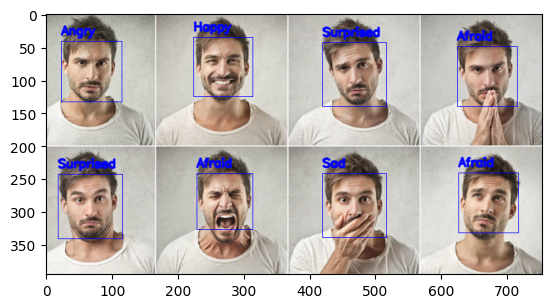

In [32]:
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))